# PID digital

In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt

## Simulation parameters

In [2]:
# Time parameters
tsim = 0.1
dt = 0.001

# Time and reference signal
t = np.arange(0, tsim, dt)
R = 6*np.ones(len(t))

## Simple step response (Ignoring saturation)

In [3]:
# Plant
num1 = [29870]
den1 = [1, 414.7, 33610]
G = ct.tf(num1, den1)

# Controller
Kp = 3.84808815
Ti = 0.00711849
Td = 0
Gc = ct.tf([Kp*Ti*Td, Kp*Ti, Kp],[Ti, 0])


# Closed-loop system
sys = ct.feedback(Gc*G)
t1, C1 = ct.forced_response(sys,t,R)

print('Plant:', G)

Plant: 
        2.987e+04
-------------------------
s^2 + 414.7 s + 3.361e+04



# Digital PID: NO Anti-windup

In [4]:
# Digital PID
ts = 0.002
b0 = Kp*(1 + (ts/(2*Ti)) + (Td/ts))
b1 = -Kp*(1 - (ts/(2*Ti)) + (2*Td/ts))
b2 = Kp*Td/ts

print('b0: {a:1.4f}, b1: {b:1.4f},b2: {c:1.4f} '.format(a=b0, b=b1, c=b2))

b0: 4.3887, b1: -3.3075,b2: 0.0000 


In [5]:
# Conver to space states to allow initial conditions
Gss = ct.tf2ss(G)

# Initial conditions
xPre = np.zeros(len(G.pole()))

# Accumulated system response
C2 = np.zeros(len(t))

# Accumulated control signal
Vacc = np.zeros(len(t))

# Accumulated control signal (saturated)
Uacc = np.zeros(len(t))

#Accumulated error
Eacc = np.zeros(len(t))

# Saturation limits
lUp = 12
lDo = -12

for i, ti in enumerate(t):
    # Error
    e = R[i] - C2[i-1]
    
    # Controller - ( Vacc[i] = U for antiWindup)
    V = b0*e + b1*Eacc[i-1] + b2*Eacc[i-2] + Vacc[i-1]
    U = max(min(V, lUp), lDo)
        
    # Plant response
    _, Ci, Xi = ct.forced_response(Gss, [ti-dt,ti], [U,U], X0 = xPre, return_x = True)
    
    # Save results
    C2[i] = np.squeeze(Ci[-1])
    xPre = np.squeeze(Xi[:,-1])
    
    Eacc[i] = e
    Vacc[i] = V
    Uacc[i] = U
    

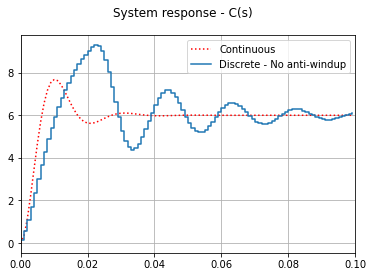

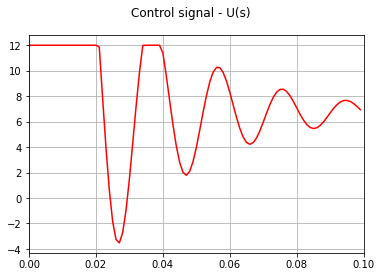

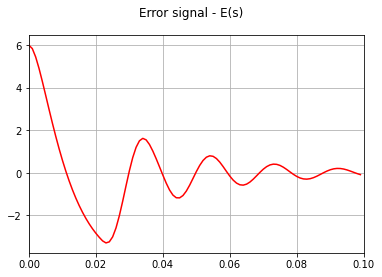

In [6]:
# Compare
plt.plot(t1, C1, 'r:', label = "Continuous" )
plt.step(t, C2, where= "post", label = "Discrete - No anti-windup")
plt.xlim((0,tsim))
plt.suptitle("System response - C(s)")
plt.legend()
plt.grid()

#Controller
plt.figure()
plt.plot(t, Uacc, 'r');
plt.xlim((0, tsim))
plt.suptitle("Control signal - U(s)")
plt.grid()

#Error
plt.figure()
plt.plot(t, Eacc, 'r');
plt.xlim((0, tsim))
plt.suptitle("Error signal - E(s)")
plt.grid()


# Digital PID: Anti-windup

In [7]:
# Conver to space states to allow initial conditions
Gss = ct.tf2ss(G)

# Initial conditions
xPre = np.zeros(len(G.pole()))

# Accumulated system response
C2 = np.zeros(len(t))

# Accumulated control signal
Vacc = np.zeros(len(t))

# Accumulated control signal (saturated)
Uacc = np.zeros(len(t))

#Accumulated error
Eacc = np.zeros(len(t))

# Saturation limits
lUp = 12
lDo = -12

for i, ti in enumerate(t):
    # Error
    e = R[i] - C2[i-1]
    
    # Controller - ( Vacc[i] = U for antiWindup)
    V = b0*e + b1*Eacc[i-1] + b2*Eacc[i-2] + Vacc[i-1]
    U = max(min(V, lUp), lDo)
        
    # Plant response
    _, Ci, Xi = ct.forced_response(Gss, [ti-dt,ti], [U,U], X0 = xPre, return_x = True)
    
    # Save results
    C2[i] = np.squeeze(Ci[-1])
    xPre = np.squeeze(Xi[:,-1])
    
    Eacc[i] = e
    Vacc[i] = U
    Uacc[i] = U
    

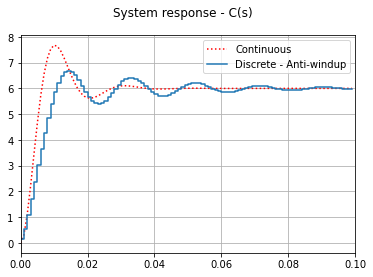

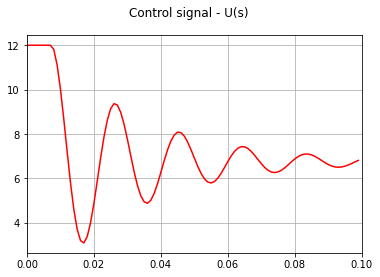

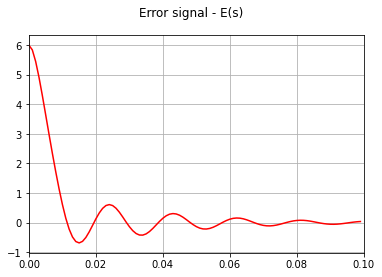

In [8]:
# Compare
plt.plot(t1, C1, 'r:', label = "Continuous" )
plt.step(t, C2, where= "post", label = "Discrete - Anti-windup")
plt.xlim((0,tsim))
plt.suptitle("System response - C(s)")
plt.legend()
plt.grid()

#Controller
plt.figure()
plt.plot(t, Uacc, 'r');
plt.xlim((0, tsim))
plt.suptitle("Control signal - U(s)")
plt.grid()

#Error
plt.figure()
plt.plot(t, Eacc, 'r');
plt.xlim((0, tsim))
plt.suptitle("Error signal - E(s)")
plt.grid()
